In [15]:
import pandas as pd
import numpy as np
import json
import re

print("Libraries imported sucessfully.")

Libraries imported sucessfully.


***Loading both the dataset***

In [16]:
codeforces_file = "D:\AutoJudge_v2\data\codeforces_data_hg.csv"
df_codeforces = pd.read_csv(codeforces_file)

print(f"\n✓ Loaded Codeforces data: {len(df_codeforces)} problems")
print(f"  Columns: {df_codeforces.columns.tolist()}")


✓ Loaded Codeforces data: 5000 problems
  Columns: ['title', 'time_limit', 'memory_limit', 'description', 'input_format', 'output_format', 'note', 'rating', 'tags']


In [17]:
existing_file = "D:\AutoJudge_v2\data\data_cleaned.csv"
df_existing = pd.read_csv(existing_file)

print(f"\n✓ Loaded existing data: {len(df_existing)} problems")
print(f"  Columns: {df_existing.columns.tolist()}")


✓ Loaded existing data: 7827 problems
  Columns: ['title', 'description', 'input_description', 'output_description', 'problem_class', 'problem_score', 'combined_text', 'problem_class_encoded', 'text_length', 'word_count']


***converting codeforces data to standard format***

In [18]:
def rating_to_difficulty(rating):
    """Converting Codeforces rating to difficulty class and score"""
    if pd.isna(rating):
        # If no rating, assign based on description length/complexity
        return 'medium', 5.0
    
    rating = float(rating)
        
    if rating < 1200:
        difficulty_class = 'easy'
    elif rating < 1800:
        difficulty_class = 'medium'
    else:
        difficulty_class = 'hard'
    
    difficulty_score = 1.0 + (min(rating, 3000) - 800) / 2200 * 9
    difficulty_score = round(difficulty_score, 2)
    
    return difficulty_class, difficulty_score

print("\nConverting ratings to difficulty classes...")

difficulties = df_codeforces['rating'].apply(rating_to_difficulty)
df_codeforces['problem_class'] = [d[0] for d in difficulties]
df_codeforces['problem_score'] = [d[1] for d in difficulties]


Converting ratings to difficulty classes...


In [19]:
df_codeforces["description"] = (
    df_codeforces["description"].fillna("") + " " +
    df_codeforces["tags"].fillna("") + " " +
    df_codeforces["note"].fillna("")
).str.strip()

***Standardizing column names***

In [20]:
df_codeforces_standard = pd.DataFrame({
    'title': df_codeforces['title'],
    'description': df_codeforces['description'].fillna(''),
    'input_description': df_codeforces['input_format'].fillna(''),
    'output_description': df_codeforces['output_format'].fillna(''),
    'problem_class': df_codeforces['problem_class'],
    'problem_score': df_codeforces['problem_score'],
    'rating': df_codeforces['rating'],
    'tags': df_codeforces['tags'].fillna(''),
    #'url': 'https://codeforces.com/problemset'  
})

print(f"✓ Converted {len(df_codeforces_standard)} problems")

✓ Converted 5000 problems


***Class Distribution***

In [21]:
print("\nCodeforces data - Class distribution:")
print(df_codeforces_standard['problem_class'].value_counts())
print("\nScore distribution:")
print(df_codeforces_standard.groupby('problem_class')['problem_score'].describe())


Codeforces data - Class distribution:
problem_class
hard      2578
medium    1434
easy       988
Name: count, dtype: int64

Score distribution:
                count      mean       std   min   25%   50%   75%    max
problem_class                                                           
easy            988.0  1.460213  0.483427  1.00  1.00  1.41  1.82   2.23
hard           2578.0  7.428359  1.633639  5.09  5.91  7.14  8.77  10.00
medium         1434.0  3.780265  0.755081  2.64  3.05  3.86  4.27   5.00


***Cleaning and validating the data***

In [22]:
def clean_text(text):
    """Cleaning text by removing extra whitespace and special characters"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to string
    text = str(text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove very long sequences of special characters
    text = re.sub(r'[^\w\s]{10,}', '', text)
    
    return text.strip()

# Clean text fields
print("\nCleaning text fields...")
for col in ['description', 'input_description', 'output_description']:
    df_codeforces_standard[col] = df_codeforces_standard[col].apply(clean_text)


Cleaning text fields...


***Merging with existing data***

In [23]:
# =========================================
# Toggle merge ON/OFF
# =========================================
MERGE_DATA = False

if df_existing is not None and MERGE_DATA:

    print("\n" + "="*70)
    print("MERGING WITH EXISTING DATA")
    print("="*70)

    required_cols = [
        'title', 'description', 'input_description',
        'output_description', 'problem_class', 'problem_score'
    ]

    existing_has_cols = all(col in df_existing.columns for col in required_cols)

    if existing_has_cols:

        df_existing_subset = df_existing[required_cols].copy()

        if 'url' not in df_existing_subset.columns:
            df_existing_subset['url'] = ''

        print(f"\nExisting data: {len(df_existing_subset)} problems")
        print(f"Codeforces data: {len(df_codeforces_standard)} problems")

        df_combined = pd.concat(
            [df_existing_subset, df_codeforces_standard],
            ignore_index=True
        )

        df_combined = df_combined.drop_duplicates(
            subset=['title'],
            keep='last'
        )

        print(f"\nCombined: {len(df_combined)} problems (after removing duplicates)")

    else:
        print("\n⚠️ Existing data has different format. Using only Codeforces data.")
        df_combined = df_codeforces_standard

elif df_existing is not None and not MERGE_DATA:

    print("\nMerging disabled. Using only Codeforces data.")
    df_combined = df_codeforces_standard

else:

    print("\nUsing only Codeforces data (no existing data to merge)")
    df_combined = df_codeforces_standard



Merging disabled. Using only Codeforces data.


***Final Dataset Statistics***

In [24]:
print("\n" + "="*70)
print("FINAL DATASET STATISTICS")
print("="*70)

print(f"\nTotal problems: {len(df_combined)}")

print("\n" + "-"*70)
print("CLASS DISTRIBUTION")
print("-"*70)
class_counts = df_combined['problem_class'].value_counts()
for cls, count in class_counts.items():
    percentage = (count / len(df_combined)) * 100
    bar = "█" * int(percentage / 2)
    print(f"  {cls:10s}: {count:5d} ({percentage:5.1f}%) {bar}")

print("\n" + "-"*70)
print("SCORE STATISTICS")
print("-"*70)
score_stats = df_combined.groupby('problem_class')['problem_score'].describe()
print(score_stats)

print("\n" + "-"*70)
print("TEXT LENGTH STATISTICS")
print("-"*70)
df_combined['combined_length'] = (
    df_combined['title'].str.len() + 
    df_combined['description'].str.len() + 
    df_combined['input_description'].str.len() + 
    df_combined['output_description'].str.len()
)

print(f"Mean combined text length: {df_combined['combined_length'].mean():.0f} chars")
print(f"Min: {df_combined['combined_length'].min():.0f} chars")
print(f"Max: {df_combined['combined_length'].max():.0f} chars")


FINAL DATASET STATISTICS

Total problems: 5000

----------------------------------------------------------------------
CLASS DISTRIBUTION
----------------------------------------------------------------------
  hard      :  2578 ( 51.6%) █████████████████████████
  medium    :  1434 ( 28.7%) ██████████████
  easy      :   988 ( 19.8%) █████████

----------------------------------------------------------------------
SCORE STATISTICS
----------------------------------------------------------------------
                count      mean       std   min   25%   50%   75%    max
problem_class                                                           
easy            988.0  1.460213  0.483427  1.00  1.00  1.41  1.82   2.23
hard           2578.0  7.428359  1.633639  5.09  5.91  7.14  8.77  10.00
medium         1434.0  3.780265  0.755081  2.64  3.05  3.86  4.27   5.00

----------------------------------------------------------------------
TEXT LENGTH STATISTICS
--------------------------------

***Saving Final Dataset***

In [25]:
print("\n" + "="*70)
print("SAVING FINAL DATASET")
print("="*70)

# Save as CSV
output_csv = 'D:\AutoJudge_v2\data\merged_problems.csv'
df_combined.to_csv(output_csv, index=False, encoding='utf-8')
print(f"✓ Saved to {output_csv}")

# Save as JSONL
output_jsonl = 'D:\AutoJudge_v2\data\merged_problems.jsonl'
with open(output_jsonl, 'w', encoding='utf-8') as f:
    for _, row in df_combined.iterrows():
        problem = {
            'title': row['title'],
            'description': row['description'],
            'input_description': row['input_description'],
            'output_description': row['output_description'],
            'problem_class': row['problem_class'],
            'problem_score': row['problem_score']
        }
        f.write(json.dumps(problem, ensure_ascii=False) + '\n')

print(f"✓ Saved to {output_jsonl}")


SAVING FINAL DATASET
✓ Saved to D:\AutoJudge_v2\data\merged_problems.csv
✓ Saved to D:\AutoJudge_v2\data\merged_problems.jsonl


***Visualizing Dataset***


VISUALIZING DATASET


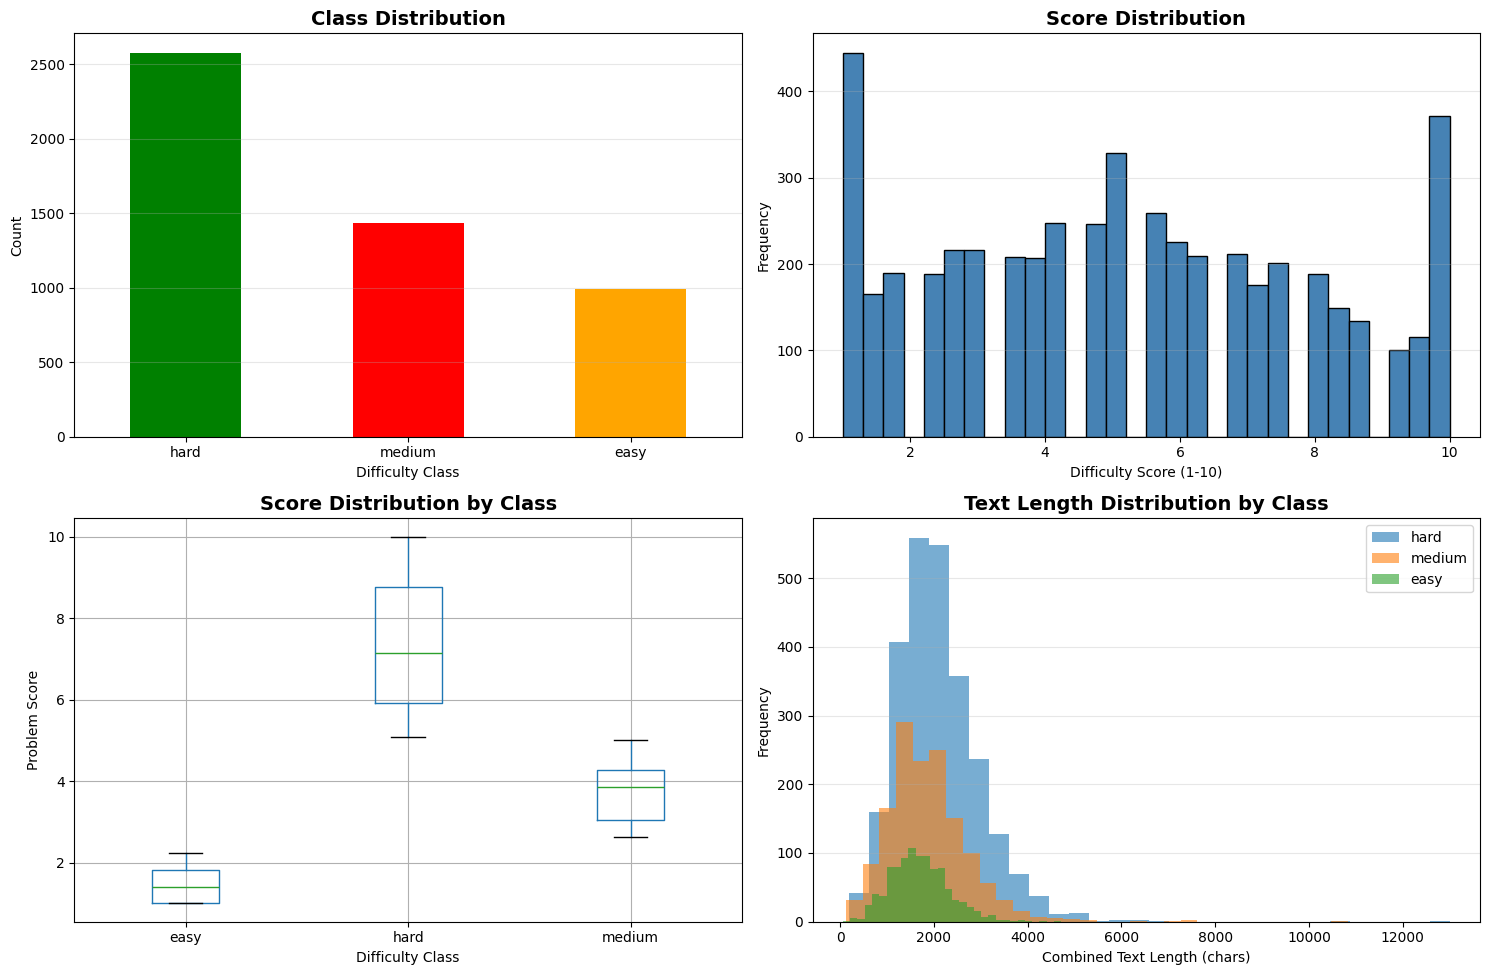

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("VISUALIZING DATASET")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class distribution
class_counts.plot(kind='bar', ax=axes[0, 0], color=['green', 'red', 'orange'])
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Difficulty Class')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Score distribution
axes[0, 1].hist(df_combined['problem_score'], bins=30, color='steelblue', edgecolor='black')
axes[0, 1].set_title('Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Difficulty Score (1-10)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Score by class (boxplot)
df_combined.boxplot(column='problem_score', by='problem_class', ax=axes[1, 0])
axes[1, 0].set_title('Score Distribution by Class', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Difficulty Class')
axes[1, 0].set_ylabel('Problem Score')
plt.suptitle('')  # Remove default title

# 4. Text length distribution by class
for cls in df_combined['problem_class'].unique():
    data = df_combined[df_combined['problem_class'] == cls]['combined_length']
    axes[1, 1].hist(data, alpha=0.6, label=cls, bins=30)
axes[1, 1].set_title('Text Length Distribution by Class', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Combined Text Length (chars)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print("\n" + "="*70)
print("✅ DATA PREPARATION COMPLETE!")
print("="*70)

print(f"\n📊 Final Dataset:")
print(f"  - Total problems: {len(df_combined)}")
print(f"  - Easy: {len(df_combined[df_combined['problem_class']=='easy'])}")
print(f"  - Medium: {len(df_combined[df_combined['problem_class']=='medium'])}")
print(f"  - Hard: {len(df_combined[df_combined['problem_class']=='hard'])}")

print(f"\n💾 Files created:")
print(f"  1. {output_csv} - For viewing")
print(f"  2. {output_jsonl} - For training")


✅ DATA PREPARATION COMPLETE!

📊 Final Dataset:
  - Total problems: 5000
  - Easy: 988
  - Medium: 1434
  - Hard: 2578

💾 Files created:
  1. D:\AutoJudge_v2\data\merged_problems.csv - For viewing
  2. D:\AutoJudge_v2\data\merged_problems.jsonl - For training
